In [32]:
import sys
import cuentitas
from auxiliares import generadorHH, generadorVV, generadorHHVV, generadorHHVVlambda

from numpy import pi, sqrt, sin, cos, exp, log10, array, real, conj
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import interpolate
import seaborn as sns
import pandas as pd
import glob
import theano.tensor as TT
import random

import time

import pymc3 as pm

sns.set() #seaborn como default

In [33]:
# A partir de generadorFran, que devuelve "2*len(anguloR)*len(landa)" valores de s0 y "2*len(landa)" valores de emi en nadir, para los parametros
# elejidos, los convierto a forma tensorial y los devuelve en subtensores

def toFitHHVV(ep1,ep2,d,s1,l1,s2,l2,anguloR,landa): #Me devuelve un tensor de nn+mm, con nn valores de angulos s0 y mm emis
    if (ep1 != ep2):
        s0HH = generadorHH(ep1,ep2,d,s1,l1,s2,l2,incAng,landa)
        s0VV = generadorVV(ep1,ep2,d,s1,l1,s2,l2,incAng,landa)
        
        hh = len(s0HH[1])
        vv = len(s0VV[1])
        
        a = TT.zeros(hh+vv)
        l = len(landa)
        
        
          #Ordeno primero s0HH y s0VV
        for i in range(0,hh-l):
            a = TT.set_subtensor(a[i], s0HH[1][i])
        for j in range(0,vv-l):
            a = TT.set_subtensor(a[hh-l+j],s0VV[1][j])
          #Ordeno emiHH y emiVV
        for m in range(0,l):
            a = TT.set_subtensor(a[hh+vv-2*l+m],s0HH[1][hh-l+m])
        for k in range(0,l):
            a = TT.set_subtensor(a[hh+vv-l+k],s0VV[1][vv-l+k])
    return a

In [3]:
#como el de arriba pero solo funciona para un unico valor de angulo y 2 lambdas

def toFitHHVVlambda(ep1,ep2,d,s1,l1,s2,l2,anguloR,landa): #HH calculado en lambda[0] y VV en [1]
    if (ep1 != ep2):
        
        landa1 = np.asarray(landa[0])
        landa2 = np.asarray(landa[1])
    
        
        s0HH = generadorHH(ep1,ep2,d,s1,l1,s2,l2,incAng,[landa[0]])
        s0VV = generadorVV(ep1,ep2,d,s1,l1,s2,l2,incAng,[landa[1]])

        hh = len(s0HH[1])
        vv = len(s0VV[1])
        
        a = TT.zeros(hh+vv)        
        
          #Ordeno primero s0HH y s0VV
        
        a = TT.set_subtensor(a[0], s0HH[1][0])
        a = TT.set_subtensor(a[1], s0VV[1][0])
        a = TT.set_subtensor(a[2], s0HH[1][1])
        a = TT.set_subtensor(a[3], s0VV[1][1])
        
    return a

In [42]:
# Resuelve mediante inferencia bayesiana utilizando algoritmo sequential monte carlo sampler (SMC) los parametros ep1,ep2,etc
# que mejor resuelven los valores de entrada. 
# La devolucion es una matriz con la distribución posterior. Este este contiene para cada columna los juegos de parametros que 
# explican los valores de entrada a partir de un cierto error sigma definido

# sector: Valores de entrada de s0 y emi de la zona estudiada, definida por "auxiliares.py/medicion()" o por una funcion que 
#         devuelta en primer lugar un array de n angulos en donde se mide y en segundo lugar un array con las mediciones. 
# angWR: es el angulo sin ruido para simulaciones con emisividad, es indistinto el valor 
#         que tome si uso la f() sin emisividad
# landa: frecuencia de operacion
# samples: cantidad de muestras del espacio de parametros
# sigmas: array error de [deltaSo, deltaEmi]


def modelo(sector, landa, samples, sigmas): 
    
    phi = np.pi
    
    print('Valores de entrada: ', sector[1])
    print('Cantidad de datos: ', sector[1].shape)

    #Rango en donde estudiamos los parametros   
    ranges = {}
    ranges['ep1'] = 1.40001, 8 #corro ligeramente el punto inicial ep1 para que no diverja con ep2 en canal HH
    ranges['ep2'] = 1.4, 8
    ranges['d'] = 0.001, 0.5
    ranges['s1'] = 0.0004, 0.004
    ranges['s2'] = 0.0004, 0.004

    #distribucion a priori de cada uno
    with pm.Model() as model:
        ep1 = pm.Uniform('ep1', ranges['ep1'][0], ranges['ep1'][1])
        ep2 = pm.Uniform('ep2', ranges['ep2'][0], ranges['ep2'][1])
        d = pm.Uniform('d', ranges['d'][0], ranges['d'][1])
        s1 = pm.Uniform('s1', ranges['s1'][0], ranges['s1'][1])
        s2 = pm.Uniform('s2', ranges['s2'][0], ranges['s2'][1])

    #Funcion de costo a minimizar
    def f(ep1 = ep1,
          ep2 = ep2,
          d = d,
          s1 = s1,
          s2 = s2):

        return toFitHHVV(ep1,ep2,d,s1,0.015,s2,0.01,sector[0],landa)
    
    with model:
        function_pm = pm.Deterministic('s0f', f()) #Funcion de costo
        observations = pm.Normal( "obs",  mu=real(function_pm), sigma=sigmas, observed=sector[1]) #observaciones
        trace = pm.sample_smc(samples, cores=4, parallel=True) #metodo de exploracion de parametros
    
    return trace

In [43]:
# Angulos estudiados en datos sinteticos. Este array debe contar con al menos 1 valor.
# landa: longitudes de onda de operacion. Este array debe contar con al menos 1 valor.

incAng = [20,60]
landa = [0.025,0.05]

In [44]:
# Prueba de la forma tensorial para ajustar
qw = toFitHHVV(1.93,
            5.0,
            0.3,
            0.001,
            0.015,
            0.002,
            0.01,
            incAng,
            landa)

qw.eval() #los primeros corresponden a los datos de HH y los segundos a VV

array([ -4.99560838, -15.41416231, -31.00460095, -27.67916625,
        -4.62545005, -14.7996328 , -25.3610854 , -21.71229563,
         0.95506814,   0.99526577,   0.95510102,   0.99527202])

In [45]:
# Datos de entrada para la inferencia

# set1
surfaceModelParam = [1.93,
                    5.0,
                    0.3,
                    0.001,
                    0.002]

entradaModelo = generadorHHVV(surfaceModelParam[0], 
                surfaceModelParam[1],
                surfaceModelParam[2],
                surfaceModelParam[3],
                0.015,
                surfaceModelParam[4],                
                0.01,
                incAng,
                landa)
entradaModelo

array([array([20, 60]),
       array([ -4.99560838, -15.41416231, -31.00460095, -27.67916625,
        -4.62545005, -14.7996328 , -25.3610854 , -21.71229563,
         0.95506814,   0.99526577,   0.95510102,   0.99527202])],
      dtype=object)

In [ ]:
t0 = time.time()

muestras = 10000
Nombre = 'Delta'

# Para una freq por canal
sig = np.asarray(2*len(incAng)*len(landa)*[0.1] + 2*len(landa)*[0.01])

# print(sig)
print(len(sig), len(qw.eval()))

traza = modelo(entradaModelo, landa, muestras, sig)

12 12
Valores de entrada:  [ -4.99560838 -15.41416231 -31.00460095 -27.67916625  -4.62545005
 -14.7996328  -25.3610854  -21.71229563   0.95506814   0.99526577
   0.95510102   0.99527202]
Cantidad de datos:  (12,)


Initializing SMC sampler...
Sampling 4 chains in 4 jobs
WARNING (theano.tensor.opt): Optimization Warning: The Op true_div does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op true_div does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op true_div does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. 

In [16]:
plotear = np.stack((traza['ep1'],traza['ep2'],traza['d'], traza['s1'], traza['s2'])).T
dfplotear = pd.DataFrame(plotear, columns = ['ep1','ep2','d','s1','s2'])

In [17]:
modelInReduced = [surfaceModelParam[0], 
                  surfaceModelParam[1],
                  surfaceModelParam[2],
                  surfaceModelParam[3],
                  surfaceModelParam[4]]

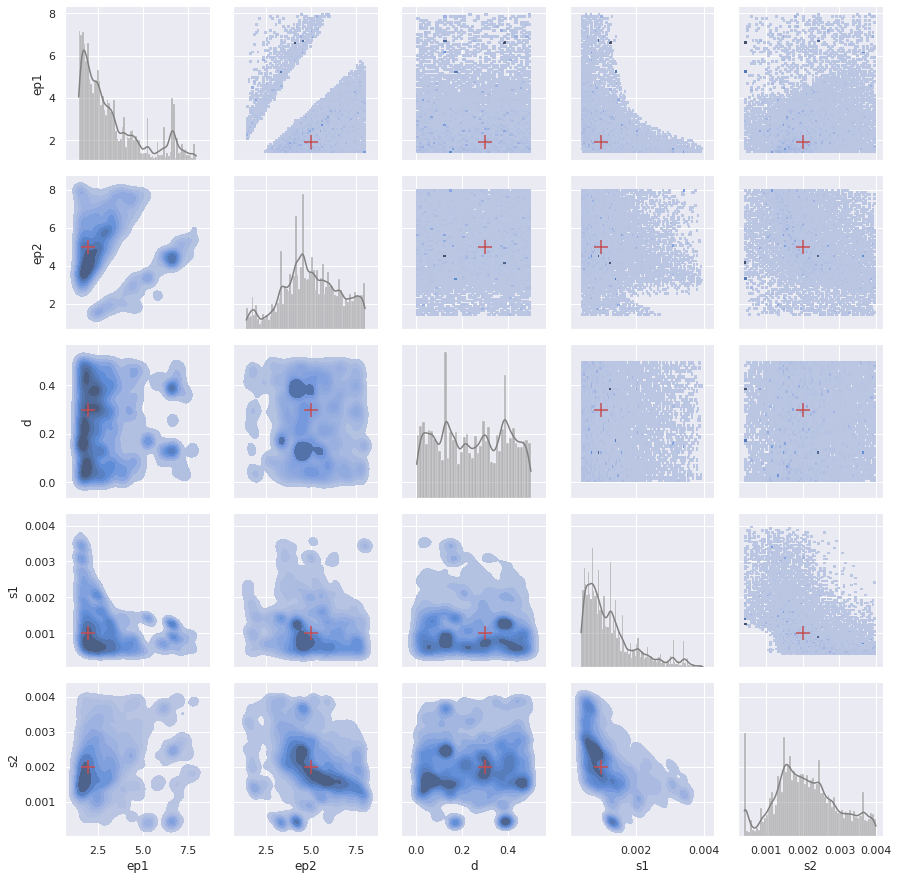

In [18]:
f = sns.PairGrid(dfplotear)
# f.fig.suptitle(Nombre, y=1.01, fontsize = 'large')
f.map_upper(sns.histplot)

f.map_lower(sns.kdeplot, fill=True)
f.map_diag(sns.histplot, kde=True, color='.5')

for i in range(5):
    for j in range(5):
        if i == j:
            #ploteo el valor verdadero en las marginales
#             f.axes[j,i].axvline(modelInReduced[i], color='r', linestyle='dashed', linewidth=1)
            pass
        else:
            f.axes[j,i].scatter(modelInReduced[i], modelInReduced[j], marker="+", c='r', s=200) #color='k', linestyle='dashed', linewidth=1)
            
            
#         f.axes[j,i].xaxis.set_label_text(xlabels[i])
#         f.axes[j,i].yaxis.set_label_text(ylabels[j])
#         f.axes[j,i].xaxis.set_label_text(xlabels[i])
#         f.axes[j,i].scatter(1,1)



In [ ]:
t1 = time.time()
print("Tiempo de ejecución:", t1-t0, 'seg','(', (t1-t0)/3600,  'hs )')

nombre = "set1-HHVVlambda-2Capas-noNoise-2s0+2emi-20000-2lambda"
# f.savefig('Resultados_HHVV/'+nombre+'.png', dpi=300)

In [ ]:
e1 = traza['ep1']
e2 = traza['ep2']
d = traza['d']
s1 = traza['s1']
s2 = traza['s2']

guardar = [e1,e2,d,s1,s2]

# f_ = np.savetxt('Resultados_HHVV/'+nombre+'Trazas.txt', guardar, delimiter=';')
# f2_ = np.savetxt('Resultados_HHVV/'+nombre+'Trazas-input.txt', np.asarray([np.asarray(incAng),np.asarray(modelInReduced)],dtype=object), fmt='%s', delimiter=';')